# Analyzing Book Data and Building Recommendation Systems

## 1. Setting Up

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML
import difflib
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_reviews = pd.read_csv('data/book_reviews.csv')
df_books = pd.read_csv('data/book_details.csv')

## 2. Data Pre-Processing

### Book Reviews Data

In [7]:
# replace user IDs with hashed identifiers for anonymization
df_reviews['user_id_hash'] = df_reviews['User_id'].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())

In [8]:
# remove profile name and user id columns
df_reviews.drop(['profileName', 'User_id'], axis=1, inplace=True)

In [9]:
df_reviews

,Id,Title,Price,review/helpfulness,review/score,review/time,review/summary,review/text,user_id_hash
0,1882931173,Its Only Art If Its Well Hung!,NaN,7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,d30b427b30933bb34ef4ebbb918f3330a2d2f996108db6...
1,0826414346,Dr. Seuss: American Icon,NaN,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,397a756046690cfa811bf3fa05ac6787b47106ac56bd2b...
2,0826414346,Dr. Seuss: American Icon,NaN,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",a69c4d66d363cbd37eb5afd2fb4ea25ec4ebf373da7bc1...
3,0826414346,Dr. Seuss: American Icon,NaN,7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",b5394a56cdac589b9a85cae41dfbd1fb0d3d407ddb4155...
4,0826414346,Dr. Seuss: American Icon,NaN,3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,95a4d058a3f27319a27d1446c57aa45f4fa31e92557c47...
...,...,...,...,...,...,...,...,...,...
2999995,B000NSLVCU,The Idea of History,NaN,14/19,4.0,937612800,Difficult,"This is an extremely difficult book to digest,...",9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...
2999996,B000NSLVCU,The Idea of History,NaN,1/1,4.0,1331683200,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...,5ddfac0c7267ef31e55d595c5ce0364c2fba86c2830cb0...
2999997,B000NSLVCU,The Idea of History,NaN,0/0,4.0,1180224000,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i...",804f2fbe72bd37da41471bde1e0a1e27a22c8e0b681624...
2999998,B000NSLVCU,The Idea of History,NaN,1/11,5.0,1163030400,"Yes, it is cheaper than the University Bookstore","My daughter, a freshman at Indiana University,...",d597ba9b3a2e9e10ead329b070780e4369484274c13188...


In [10]:
df_reviews.isnull().sum()

Id                          0
Title                     208
Price                 2518829
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
user_id_hash                0
dtype: int64

In [11]:
# drop rows where title is null (title is a key feature for recommendation)
df_reviews.dropna(subset=['Title'], inplace=True)

In [12]:
# remove duplicates
df_reviews.drop_duplicates(inplace=True)

In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2991018 entries, 0 to 2999999
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   review/helpfulness  object 
 4   review/score        float64
 5   review/time         int64  
 6   review/summary      object 
 7   review/text         object 
 8   user_id_hash        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 228.2+ MB


In [14]:
# convert 'review/time' to datetime
df_reviews['review/time'] = pd.to_datetime(df_reviews['review/time'], unit='s')

### Book Details Data

In [16]:
df_books.isnull().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25305
infoLink          23836
categories        41199
ratingsCount     162652
dtype: int64

In [17]:
missing_data = df_books.isnull().mean() * 100
missing_data

Title             0.000471
description      32.222557
authors          14.789270
image            24.516958
previewLink      11.222011
publisher        35.727199
publishedDate    11.913617
infoLink         11.222011
categories       19.396527
ratingsCount     76.576712
dtype: float64

In [18]:
# fill missing values
df_books.fillna({'publisher': 'Unknown', 'categories': 'Unknown', 'authors': 'Unknown',
                 'description': 'No description available'}, inplace=True)

In [19]:
# drop rows where title is null
df_books.dropna(subset=['Title'], inplace=True)

In [20]:
# fill missing ratingsCount values in df_books with the corresponding average review/score from df_reviews if available
avg_review_score = df_reviews.groupby('Title')['review/score'].mean().reset_index()
avg_review_score.columns = ['Title', 'avg_review_score']
avg_review_score

,Title,avg_review_score
0,""" Film technique, "" and, "" Film acting """,4.500000
1,""" We'll Always Have Paris"": The Definitive Gui...",5.000000
2,"""... And Poetry is Born ..."" Russian Classical...",4.000000
3,"""A Titanic hero"" Thomas Andrews, shipbuilder",4.875000
4,"""A Truthful Impression of the Country"": Britis...",4.000000
...,...,...
212398,with an everlasting love,4.761905
212399,work and Motivation,5.000000
212400,www.whitbread.org/book,2.666667
212401,xBase Programming for the True Beginner: An In...,5.000000


In [21]:
df_books = df_books.merge(avg_review_score, on='Title', how='left')
df_books['ratingsCount'] = df_books['ratingsCount'].combine_first(df_books['avg_review_score'])

df_books.drop('avg_review_score', axis=1, inplace=True)

In [22]:
# remove duplicates
df_books.drop_duplicates(inplace=True)

In [23]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212403 entries, 0 to 212402
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    212403 non-null  object 
 2   authors        212403 non-null  object 
 3   image          160328 non-null  object 
 4   previewLink    188567 non-null  object 
 5   publisher      212403 non-null  object 
 6   publishedDate  187098 non-null  object 
 7   infoLink       188567 non-null  object 
 8   categories     212403 non-null  object 
 9   ratingsCount   212403 non-null  float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [24]:
# function to handle different date formats in publishedDate and convert them to datetime
def extract_year(date_str):
    if pd.isna(date_str):
        return np.nan
    date_str = str(date_str).strip()  # convert to string and strip any extra whitespace

    # handle format: YYYY
    if len(date_str) == 4 and date_str.isdigit():
        return int(date_str)

    # handle format: YYYY-MM
    elif len(date_str) == 7 and date_str[4] == '-' and date_str[:4].isdigit() and date_str[5:].isdigit():
        return int(date_str[:4])
    
    # handle format: YYYY-MM-DD
    elif len(date_str) >= 10 and date_str.count('-') == 2:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce').year
        except ValueError:
            return np.nan
    
    # handle format: YYYY-MM-DD with time informatio
    elif len(date_str) >= 19 and date_str.count('-') == 2 and date_str.count(':') >= 1:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S', errors='coerce').year
        except ValueError:
            return np.nan

    return np.nan

# create a new column publishedYear
df_books['publishedYear'] = df_books['publishedDate'].apply(extract_year)

In [25]:
# convert non-nan publishedYear values to int
df_books['publishedYear'] = df_books['publishedYear'].fillna(-1).astype('int64')
df_books['publishedYear'] = df_books['publishedYear'].replace(-1, pd.NA)

In [26]:
df_books

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,publishedYear
0,Its Only Art If Its Well Hung!,No description available,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,Unknown,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],4.000000,1996
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],4.555556,2005
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,Unknown,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],5.000000,2000
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],3.718750,2005
4,"Nation Dance: Religion, Identity and Cultural ...",No description available,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,Unknown,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,Unknown,5.000000,2003
...,...,...,...,...,...,...,...,...,...,...,...
212398,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.000000,2000
212399,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,Unknown,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,Unknown,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],5.000000,1995
212400,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,Unknown,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,Unknown,4.666667,2018
212401,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.000000,2003


### Merged Data

In [28]:
# merge 2 datasets on 'title'
df_combined = pd.merge(df_reviews, df_books, on='Title', how='left')

In [29]:
# calculate average rating for each book (mean of review/score)
df_combined['average_rating'] = df_combined[df_combined['review/score'].notna()].groupby('Id')['review/score'].transform('mean')

# calculate the total number of ratings (exclude na values in review/score)
df_combined['total_ratings'] = df_combined[df_combined['review/score'].notna()].groupby('Id')['review/score'].transform('count')

df_combined

,Id,Title,Price,review/helpfulness,review/score,review/time,review/summary,review/text,user_id_hash,description,...,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,publishedYear,average_rating,total_ratings
0,1882931173,Its Only Art If Its Well Hung!,NaN,7/7,4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,d30b427b30933bb34ef4ebbb918f3330a2d2f996108db6...,No description available,...,http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,Unknown,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],4.000000,1996,4.000000,1
1,0826414346,Dr. Seuss: American Icon,NaN,10/10,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,397a756046690cfa811bf3fa05ac6787b47106ac56bd2b...,Philip Nel takes a fascinating look into the k...,...,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],4.555556,2005,4.555556,9
2,0826414346,Dr. Seuss: American Icon,NaN,10/11,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t...",a69c4d66d363cbd37eb5afd2fb4ea25ec4ebf373da7bc1...,Philip Nel takes a fascinating look into the k...,...,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],4.555556,2005,4.555556,9
3,0826414346,Dr. Seuss: American Icon,NaN,7/7,4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",b5394a56cdac589b9a85cae41dfbd1fb0d3d407ddb4155...,Philip Nel takes a fascinating look into the k...,...,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],4.555556,2005,4.555556,9
4,0826414346,Dr. Seuss: American Icon,NaN,3/3,4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,95a4d058a3f27319a27d1446c57aa45f4fa31e92557c47...,Philip Nel takes a fascinating look into the k...,...,http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],4.555556,2005,4.555556,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991013,B000NSLVCU,The Idea of History,NaN,14/19,4.0,1999-09-18,Difficult,"This is an extremely difficult book to digest,...",9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,"Robin George Collingwood, FBA (1889 - 1943) wa...",...,http://books.google.com/books/content?id=1aLtu...,http://books.google.nl/books?id=1aLtuAEACAAJ&d...,White Press,2018-06-21,http://books.google.nl/books?id=1aLtuAEACAAJ&d...,['History'],3.000000,2018,4.272727,11
2991014,B000NSLVCU,The Idea of History,NaN,1/1,4.0,2012-03-14,Quite good and ahead of its time occasionally,This is pretty interesting. Collingwood seems ...,5ddfac0c7267ef31e55d595c5ce0364c2fba86c2830cb0...,"Robin George Collingwood, FBA (1889 - 1943) wa...",...,http://books.google.com/books/content?id=1aLtu...,http://books.google.nl/books?id=1aLtuAEACAAJ&d...,White Press,2018-06-21,http://books.google.nl/books?id=1aLtuAEACAAJ&d...,['History'],3.000000,2018,4.272727,11
2991015,B000NSLVCU,The Idea of History,NaN,0/0,4.0,2007-05-27,Easier reads of those not well versed in histo...,"This is a good book but very esoteric. ""What i...",804f2fbe72bd37da41471bde1e0a1e27a22c8e0b681624...,"Robin George Collingwood, FBA (1889 - 1943) wa...",...,http://books.google.com/books/content?id=1aLtu...,http://books.google.nl/books?id=1aLtuAEACAAJ&d...,White Press,2018-06-21,http:

In [30]:
df_combined.isnull().sum()

Id                          0
Title                       0
Price                 2510653
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
user_id_hash                0
description                 0
authors                     0
image                  538679
previewLink            329541
publisher                   0
publishedDate          353315
infoLink               329541
categories                  0
ratingsCount                0
publishedYear          356770
average_rating              0
total_ratings               0
dtype: int64

In [31]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991018 entries, 0 to 2991017
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   Id                  object        
 1   Title               object        
 2   Price               float64       
 3   review/helpfulness  object        
 4   review/score        float64       
 5   review/time         datetime64[ns]
 6   review/summary      object        
 7   review/text         object        
 8   user_id_hash        object        
 9   description         object        
 10  authors             object        
 11  image               object        
 12  previewLink         object        
 13  publisher           object        
 14  publishedDate       object        
 15  infoLink            object        
 16  categories          object        
 17  ratingsCount        float64       
 18  publishedYear       object        
 19  average_rating      float64       
 20  to

## 3. Exploratory Data Analysis (EDA)

### Rating Distribution

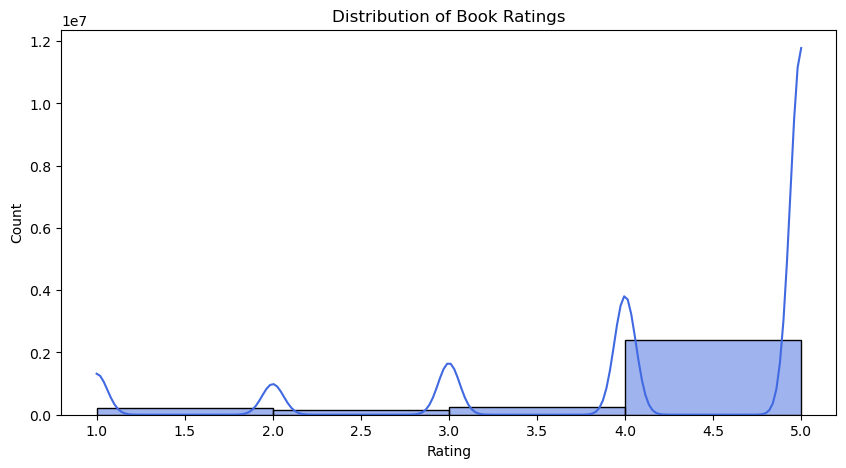

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['review/score'].dropna(), bins=4, kde=True, color='royalblue')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Comment:

- The higher concentration of ratings above 3 stars highlights a possible trend where users may prefer rating books they liked or were recommended. This could imply selection bias, where users are more likely to review books they expected to enjoy, resulting in an upward skew in the ratings.

### Most Popular Book Genres

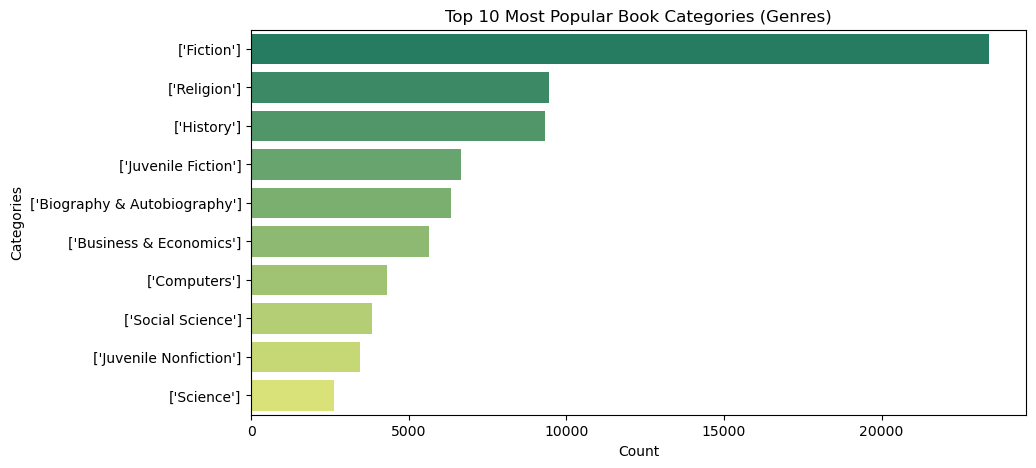

In [37]:
plt.figure(figsize=(10, 5))

# filter out 'unknown' from the categories
filtered_categories = df_books[df_books['categories'] != 'Unknown']['categories'].value_counts().head(10)
sns.barplot(x=filtered_categories.values, y=filtered_categories.index, palette='summer')
plt.title('Top 10 Most Popular Book Categories (Genres)')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.show()

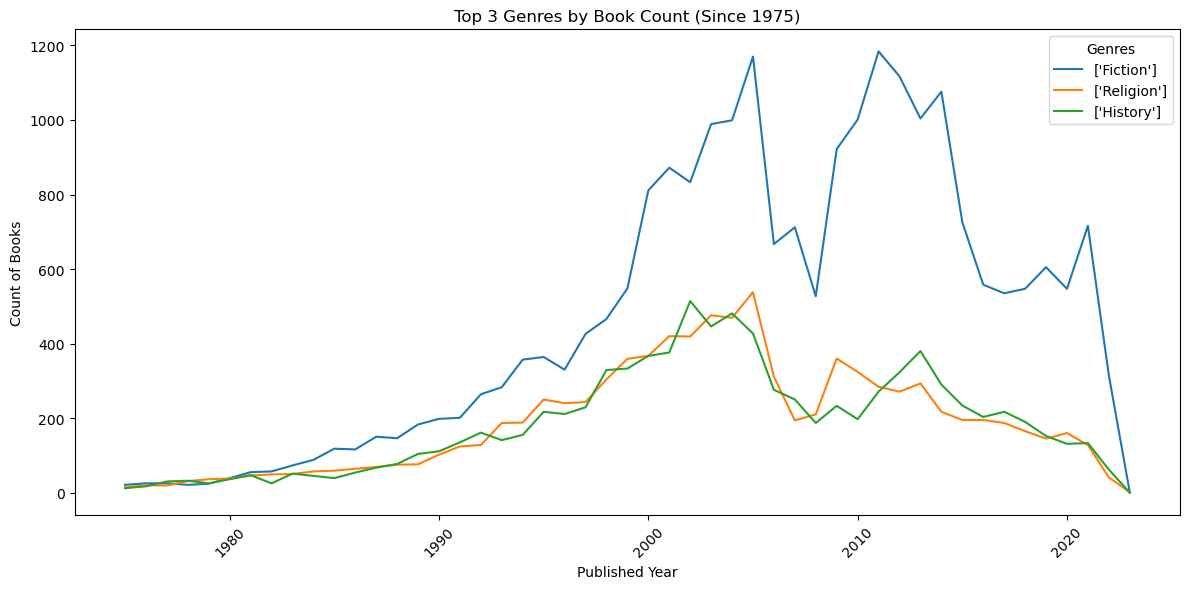

In [38]:
# filter out unknown from the categories and filter books published since 1975
filtered_books = df_books[(df_books['categories'] != 'Unknown') & (df_books['publishedYear'] >= 1975)]

# top 3 genres by book count
top_3_genres_all_time = df_books[df_books['categories'] != 'Unknown']['categories'].value_counts().nlargest(3).index

filtered_books_top3 = filtered_books[filtered_books['categories'].isin(top_3_genres_all_time)]

# book count by year and genre
genre_year_counts_top3 = filtered_books_top3.groupby(['publishedYear', 'categories']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for genre in top_3_genres_all_time:
    sns.lineplot(x=genre_year_counts_top3.index, y=genre_year_counts_top3[genre], label=genre)

plt.title('Top 3 Genres by Book Count (Since 1975)')
plt.xlabel('Published Year')
plt.ylabel('Count of Books')

plt.legend(title='Genres')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comments:

- The bar plot reveals that fiction dominates the book market, with significantly higher counts than any other genre. This suggests a strong preference for storytelling and imaginative content among readers.

- Genres like science and other informational categories appear to be less popular, indicating that readers may be less inclined towards academic or technical subjects in their leisure reading. The lower popularity of these genres could signal an opportunity for publishers to innovate within these areas, possibly blending educational content with storytelling elements to attract a broader readership.

- The line plots reveals that while religion and history genres display similar trends, fiction's impressive book count creates a noticeable divide. The substantial drop in 2009 could potentially be linked to broader economic challenges, and the subsequent decline in 2017-2018 could indicate a shifting landscape in publishing trends or reader interests.

### Distribution of Book Prices

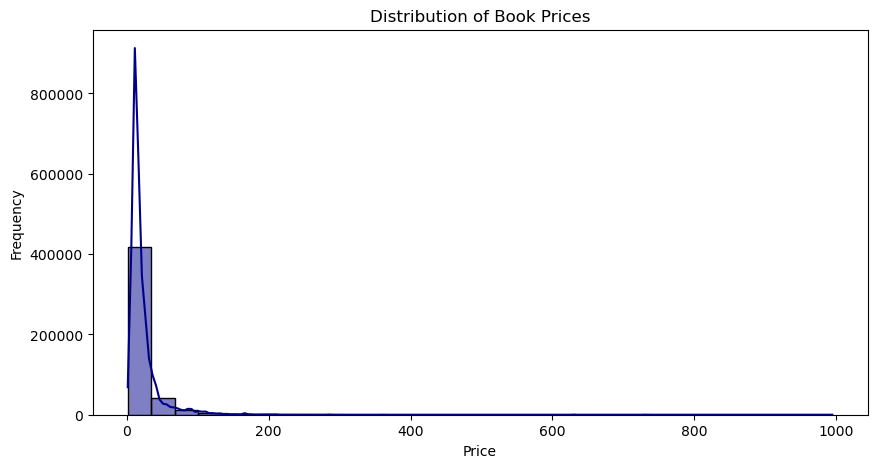

In [41]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['Price'].dropna(), bins=30, kde=True, color='darkblue')
plt.title('Distribution of Book Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

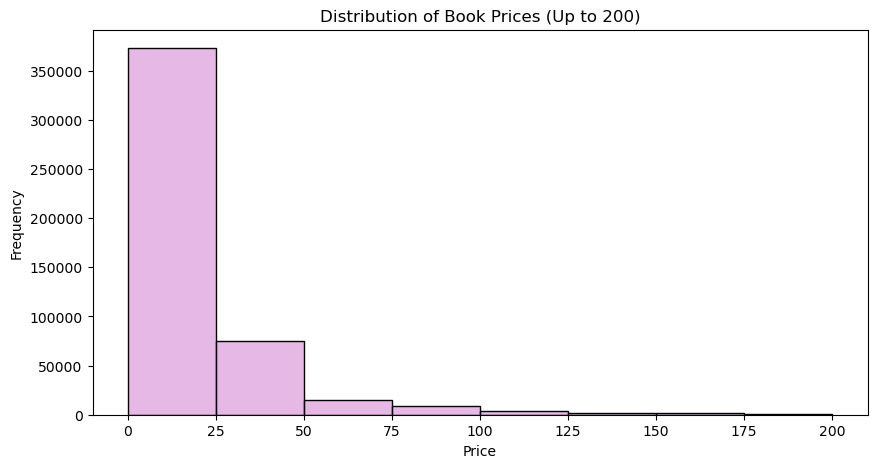

In [42]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['Price'], bins=[0, 25, 50, 75, 100, 125, 150, 175, 200], color='plum', edgecolor='black')
plt.title('Distribution of Book Prices (Up to 200)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

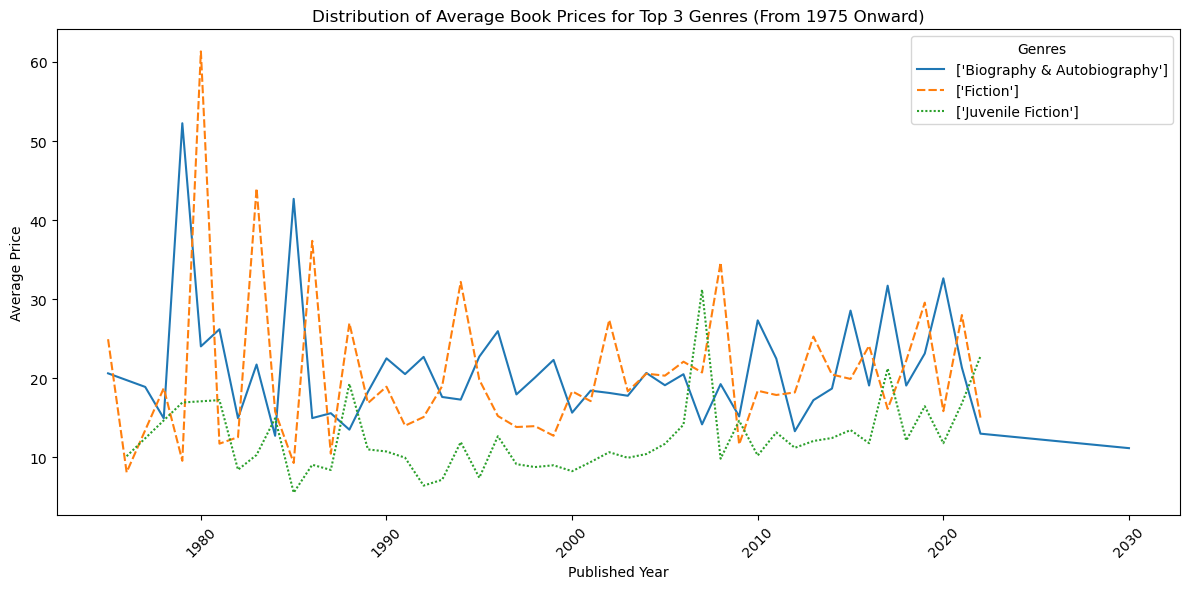

In [43]:
# filter out unknown or missing genres and books published since 1975
filtered_books = df_combined[(~df_combined['categories'].isin(['Unknown', None, '']))]
filtered_books = filtered_books[filtered_books['publishedYear'] >= 1975]

# top 3 genres by total book count across all years
top_genres = filtered_books['categories'].value_counts().nlargest(3).index

filtered_top_genres = filtered_books[filtered_books['categories'].isin(top_genres)]

# group by published year and genre, calculating the average price
average_price_by_genre = filtered_top_genres.groupby(['publishedYear', 'categories'])['Price'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_price_by_genre)
plt.title('Distribution of Average Book Prices for Top 3 Genres (From 1975 Onward)')
plt.xlabel('Published Year')
plt.ylabel('Average Price')
plt.legend(title='Genres', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comments:

- The distribution of book prices reveals that most books are priced under 100, suggesting that the majority of offerings are accessible to a broad audience. However, there are notable outliers with prices reaching up to 1000, representing premium or specialized editions.

- From 1990 onward, the average prices for Fiction and Biography books settled around 20-30. This might show that readers are consistently willing to pay this price for these popular genres.

- For Juvenile Fiction, the price was about 10 from 1990 to 2005, which could be because publishers wanted to make these books affordable for children and families. The price for Juvenile Fiction increased afterward, indicating that children's literature is gaining more recognition and value.

- Before 1990, prices were generally higher, which suggests that book production and marketing were more expensive back then.

### Distribution of Ratings Count

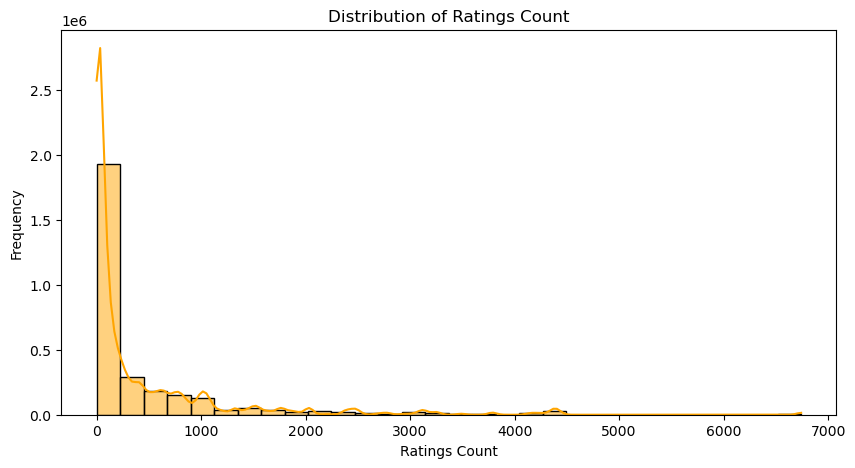

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['total_ratings'].dropna(), bins=30, kde=True, color='orange')
plt.title('Distribution of Ratings Count')
plt.xlabel('Ratings Count')
plt.ylabel('Frequency')
plt.show()

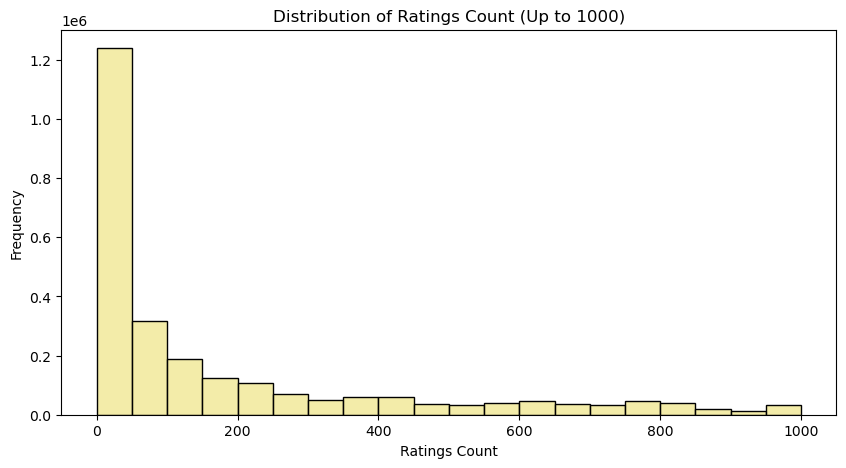

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined['total_ratings'], bins=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000], color='khaki', edgecolor='black')
plt.title('Distribution of Ratings Count (Up to 1000)')
plt.xlabel('Ratings Count')
plt.ylabel('Frequency')
plt.show()

Comment:

- The ratings count distribution is highly skewed. 

- While the range extends up to 7000 ratings, most books have fewer than 1000 ratings, with a considerable concentration under 50, indicating that only a small subset of books receive significant attention.

### Average Review Score by Book Price

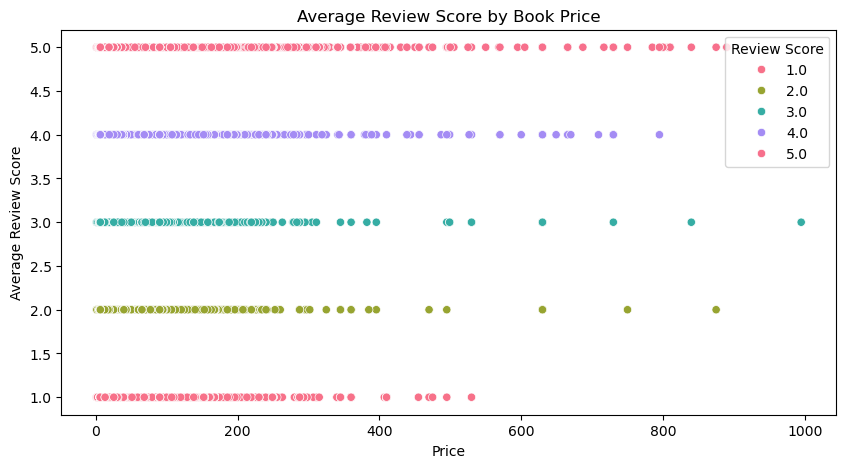

In [50]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Price', y='review/score', data=df_combined.dropna(subset=['Price', 'review/score']), hue='review/score', palette='husl')
plt.title('Average Review Score by Book Price')
plt.xlabel('Price')
plt.ylabel('Average Review Score')
plt.legend(title='Review Score', loc='upper right')
plt.show()

Comments:

- Price Distribution: The scatterplot indicates that most books are priced below 400, suggesting a preference for budget-friendly options among consumers.

- Diverse Pricing for Top-Rated Books: Interestingly, books that have received a 5-star review score display a wide variety of prices, indicating that high quality is available across both lower and higher price points. Also, the varying prices of books with high ratings could imply that readers are willing to pay more for perceived quality, as indicated by their higher review scores.

- Low Rating Price Limitation: Conversely, books rated with 1 star appear to have no prices exceeding $600, indicating a correlation between low ratings and lower price points, which may imply that less popular books are often offered at a discount.

- Concentration of Ratings: The data shows that most reviews cluster around the lower price range, which may suggest a potential market strategy focusing on affordability to attract more readers.

### Top Publishers with Most Books

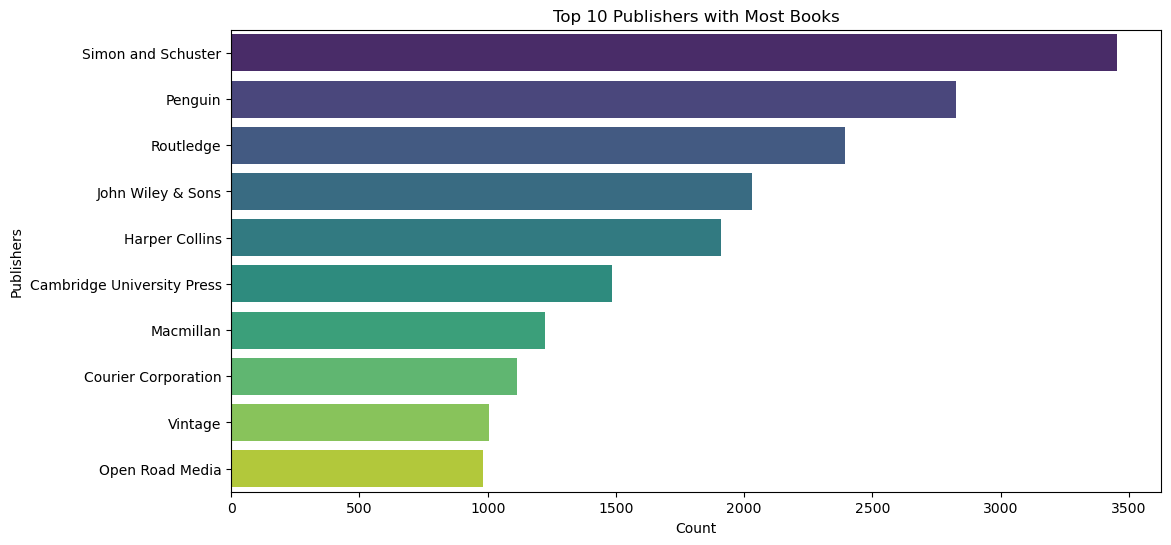

In [53]:
plt.figure(figsize=(12, 6))

# filter out unknown or missing publishers
filtered_publishers = df_books[~df_books['publisher'].isin(['Unknown', None, ''])]
publisher_counts = filtered_publishers['publisher'].value_counts().head(10)

sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='viridis')
plt.title('Top 10 Publishers with Most Books')
plt.xlabel('Count')
plt.ylabel('Publishers')
plt.show()

Comment:

- The bar plot showcases the dominance of key players in the publishing industry, including several from the Big Five, which is no surprise given their extensive catalogs and marketing reach.

### Most Reviewed Books

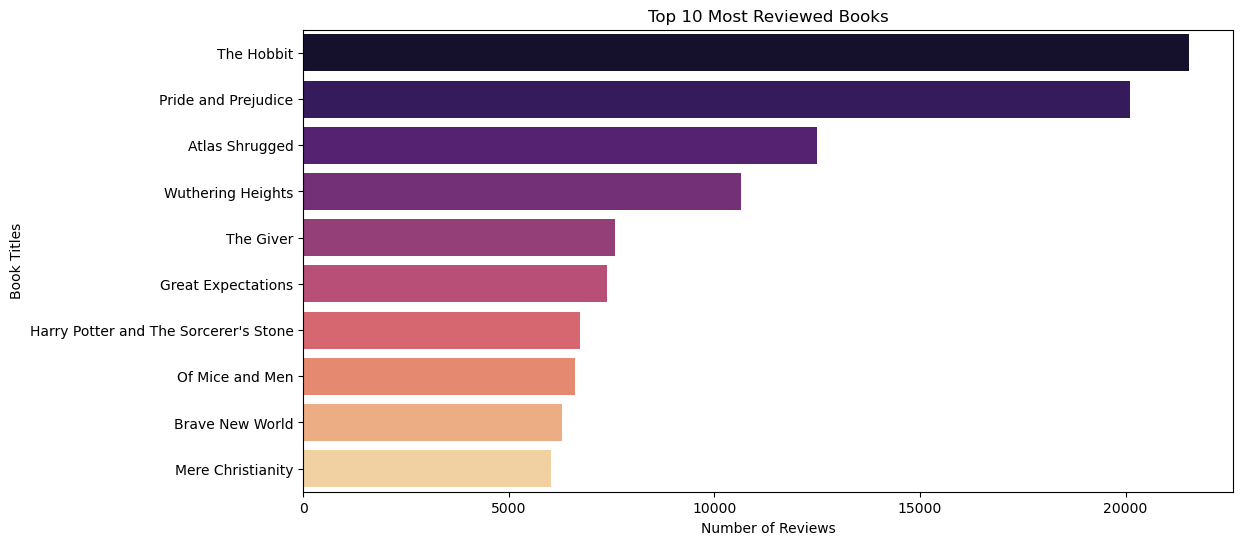

In [56]:
plt.figure(figsize=(12, 6))
top_books = df_reviews['Title'].value_counts().head(10)
sns.barplot(x=top_books.values, y=top_books.index, palette='magma')
plt.title('Top 10 Most Reviewed Books')
plt.xlabel('Number of Reviews')
plt.ylabel('Book Titles')
plt.show()

Comment:

- The data reveals a remarkable distinction in the number of reviews for 'The Hobbit' and 'Pride and Prejudice,' which stand out as clear frontrunners. This substantial gap suggests that these classics continue to resonate with readers and generate discussions long after their publication.

### Distribution of Published Years

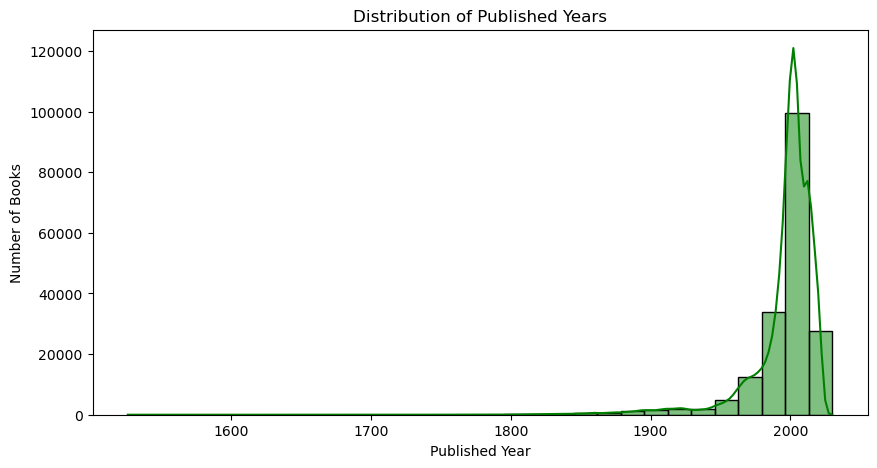

In [59]:
plt.figure(figsize=(10, 5))
sns.histplot(df_books['publishedYear'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribution of Published Years')
plt.xlabel('Published Year')
plt.ylabel('Number of Books')
plt.show()

Comments:

- The number of books published before 1900 was quite small, indicating how much the publishing industry has changed over time. After the 1950s, we see a steady increase, which suggests that more people could publish their work and were eager to read different kinds of books.

- The biggest spike in published works occurred from 2000 to 2015, likely due to the rise of digital publishing, allowing more authors to share their stories.

### Top Authors with Most Books

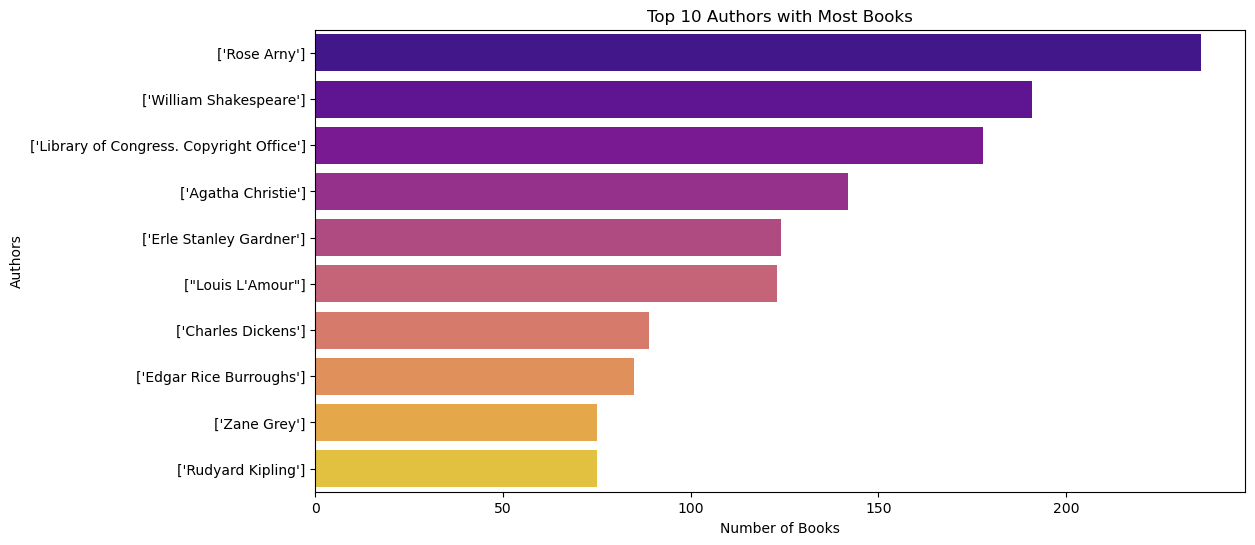

In [62]:
plt.figure(figsize=(12, 6))

# filter out unknown or missing authors
filtered_authors = df_books[~df_books['authors'].isin(['Unknown', None, ''])]
unique_books = filtered_authors.drop_duplicates(subset=['Title', 'authors'])

author_counts = unique_books['authors'].value_counts().head(10)

sns.barplot(x=author_counts.values, y=author_counts.index, palette='plasma')
plt.title('Top 10 Authors with Most Books')
plt.xlabel('Number of Books')
plt.ylabel('Authors')
plt.show()

Comment:

- Rose Arny leads the list due to her significant contributions as an editor and publisher rather than a traditional author, reflecting her influence in the publishing industry. We also see renowned authors such as William Shakespeare, Agatha Christie, whose literary masterpieces have stood the test of time.

### Word Cloud for Book Reviews

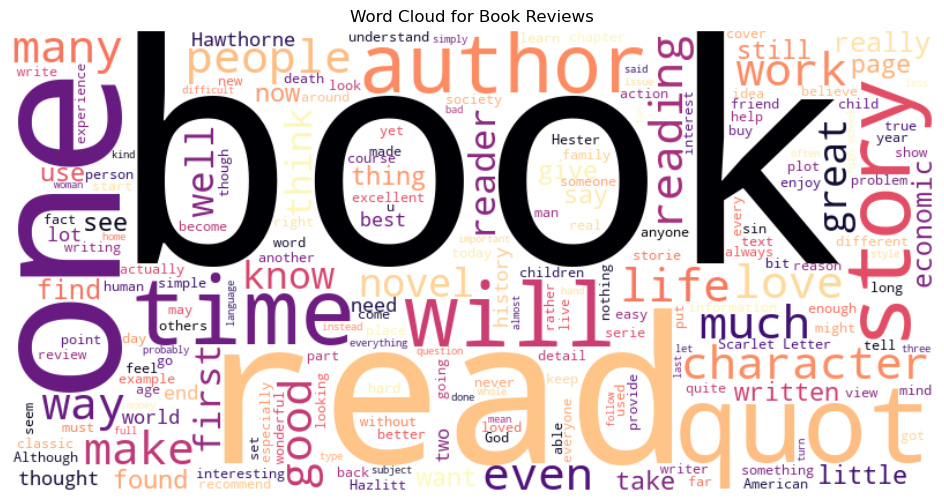

In [65]:
stopwords = set(STOPWORDS)

# concatenate reviews and remove stopwords
text = ' '.join(df_combined['review/text'].dropna().head(5000))

# generate the word cloud
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white', colormap='magma', max_words=200).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud for Book Reviews')
plt.show()

Comments:

- The word cloud shows that 'book' and 'read' are the most frequent terms, highlighting the focus on reading experiences in reviews.
- Common words like 'story' and 'character' suggest that readers really enjoy discussing the plots and characters of the books they read.

### Word Cloud for Book Titles

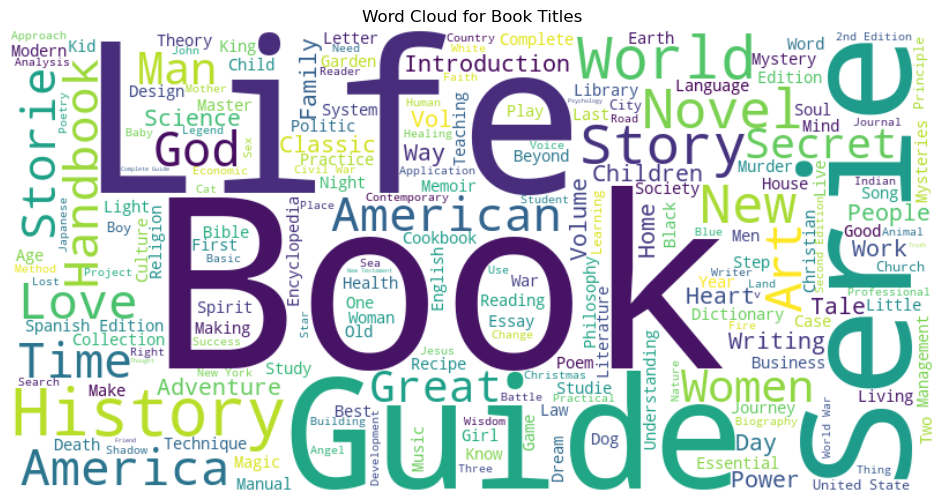

In [68]:
plt.figure(figsize=(12, 6))

# concatenate all book titles into a single string
titles = ' '.join(df_books['Title'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(titles)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Cloud for Book Titles')
plt.show()

Comments:

- The word cloud highlights 'life' and 'book' as prominent themes, indicating a focus on personal journeys and reading experiences.
- 'World' and 'history' appear frequently, showing a strong interest in books that explore different cultures and historical events.

## 4. Recommendation System

### 4.1. Collaborative Filtering

#### Item-Based Collaborative Filtering

#### Recommendations based on books that other users with similar preferences also enjoyed.

In [114]:
# prepare the dataset
df_item = df_combined[['Id', 'Title', 'authors', 'user_id_hash', 'review/score', 'image', 'average_rating', 'total_ratings', 'publishedDate']]

# assign a unique numeric ID to each user
user_id_mapping = {hash_id: i for i, hash_id in enumerate(df_item['user_id_hash'].unique(), start=1)}
df_item['user_id_numeric'] = df_item['user_id_hash'].map(user_id_mapping)

# subset the data
subset_users = df_item['user_id_numeric'].unique()[:20000]
df_subset = df_item[df_item['user_id_numeric'].isin(subset_users)]

# create the user-item matrix
user_item_matrix = df_subset.pivot_table(index='user_id_numeric', columns='Title', values='review/score', fill_value=0)
user_item_sparse = csr_matrix(user_item_matrix.values)

# use KNN to find similar items
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(user_item_sparse.T)

# function to clean and deduplicate book titles
def clean_book_titles(df, title_column):
    cleaned_titles = []
    for title in df[title_column]:
        similar_titles = difflib.get_close_matches(title, cleaned_titles, n=1, cutoff=0.85)
        if not similar_titles:
            cleaned_titles.append(title)
    return df[df[title_column].isin(cleaned_titles)]

# function to recommend books similar to those rated highly by the user
def knn_item_based_recommendations(user_id_numeric, num_recommendations=5):
    if user_id_numeric not in user_item_matrix.index:
        raise ValueError(f"User ID '{user_id_numeric}' not found in dataset.")
    
    user_ratings = user_item_matrix.loc[user_id_numeric]
    high_rated_books = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.DataFrame(columns=['Id', 'Title', 'authors', 'image', 'average_rating', 'total_ratings'])
    recommended_titles = set(high_rated_books)

    for book in high_rated_books:
        book_idx = user_item_matrix.columns.get_loc(book)
        book_sparse = user_item_sparse.T[book_idx]

        distances, indices = model_knn.kneighbors(book_sparse, n_neighbors=num_recommendations + len(high_rated_books) + 1)
        similar_books_indices = indices.flatten()[1:]
        similar_books_titles = user_item_matrix.columns[similar_books_indices]

        new_recommendations = df_item[df_item['Title'].isin(similar_books_titles.difference(recommended_titles)) & df_item['image'].notnull()]
        new_recommendations = new_recommendations.groupby(['Id', 'Title', 'authors', 'image']).agg(
            average_rating=('average_rating', 'mean'),
            total_ratings=('total_ratings', 'mean')
        ).reset_index()
        
        recommendations = pd.concat([recommendations, new_recommendations])
        recommended_titles.update(new_recommendations['Title'].tolist())

        if len(recommendations) >= num_recommendations:
            break

    return clean_book_titles(recommendations.drop_duplicates(subset=['Title']), 'Title').head(num_recommendations)

# function to display recommended books
def display_recommended_books_with_image(user_id_numeric, user_id_hash, recommended_books):
    recommendations = recommended_books.rename(columns={
        'Id': 'book_id',
        'Title': 'title',
        'average_rating': 'average_rating',
        'total_ratings': 'ratings_count',
        'image': 'book_cover'
    })
    
    recommendations = recommendations[['book_id', 'title', 'authors', 'average_rating', 'ratings_count', 'book_cover']]
    recommendations['book_cover'] = recommendations['book_cover'].apply(lambda url: f'<img src="{url}" width="100" height="150">')
    
    display(HTML(f"<h3>Item-Based Collaborative Filtering</h3><h4>Books Recommended for the Selected User</h4><h5>Based on books often rated similarly to the selected user’s favorites, reflecting common preferences among readers.</h5>"))
    display(HTML(recommendations.to_html(escape=False, index=False)))

# function to display books rated highly by the user
def display_user_high_rated_books_with_image(user_id_numeric, user_id_hash, num_books=5):
    if user_id_numeric not in user_item_matrix.index:
        raise ValueError(f"User ID '{user_id_numeric}' not found in dataset.")
    
    user_ratings = user_item_matrix.loc[user_id_numeric]
    high_rated_books = user_ratings[user_ratings > 0].index.tolist()
    
    high_rated_books_info = df_item[df_item['Title'].isin(high_rated_books)]
    high_rated_books_info = high_rated_books_info.merge(
        user_ratings[high_rated_books].reset_index().rename(columns={user_id_numeric: 'user_rating'}),
        left_on='Title', 
        right_on='Title',
        how='inner'
    )

    high_rated_books_info = high_rated_books_info.drop_duplicates(subset=['Title'])
    high_rated_books_info = high_rated_books_info.sort_values(by='user_rating', ascending=False).head(num_books)

    high_rated_books_info = high_rated_books_info.groupby(['Id', 'Title', 'authors', 'image']).agg(
        average_rating=('average_rating', 'mean'),
        user_rating=('user_rating', 'mean'),
        total_ratings=('total_ratings', 'mean')
    ).reset_index()
    
    high_rated_books_info = high_rated_books_info.rename(columns={
        'Id': 'book_id',
        'Title': 'title',
        'average_rating': 'average_rating',
        'user_rating': 'user_rating',
        'total_ratings': 'ratings_count',
        'image': 'book_cover'
    })
    
    high_rated_books_info = high_rated_books_info[['book_id', 'title', 'authors', 'average_rating', 'user_rating', 'ratings_count', 'book_cover']]
    high_rated_books_info['book_cover'] = high_rated_books_info['book_cover'].apply(lambda url: f'<img src="{url}" width="100" height="150">')
    
    display(HTML(f"<p>Enter User Numeric ID: {user_id_numeric}</p><p>User Hash ID: {user_id_hash}</p><h4>Books Rated Highly by the Selected User</h4>"))
    display(HTML(high_rated_books_info.to_html(escape=False, index=False)))

# example
user_id_numeric = 60
user_id_hash = df_item[df_item['user_id_numeric'] == user_id_numeric]['user_id_hash'].iloc[0]

# display highly rated books
display_user_high_rated_books_with_image(user_id_numeric, user_id_hash)

# get recommendations
recommended_books = knn_item_based_recommendations(user_id_numeric)

# display recommendations
display_recommended_books_with_image(user_id_numeric, user_id_hash, recommended_books)

book_id,title,authors,average_rating,user_rating,ratings_count,book_cover
0156225921,Cooking from an Italian Garden,['Editors of Phaidon Press'],4.428571,5.0,7.0,
0786811498,Yettele's Feathers,['Joan Rothenberg'],5.000000,5.0,1.0,
B0006NQJFQ,New York September 11,"['Magnum (Paris, França)']",3.758621,5.0,58.0,
B000MX0488,"What Happened in Palestine: The Events of August, 1929: Their Background and Significance",['Maurice Samuel'],5.000000,5.0,1.0,


book_id,title,authors,average_rating,ratings_count,book_cover
006100815X,Errors in English and Ways to Correct Them (Harpercollins Reference Library),['Harry Shaw'],4.500000,4.0,
014006687X,"Listen to Your Pain: The Active Person's Guide to Understanding, Identifying, and Treating Pain and Injury",['Ben E. Benjamin'],4.941176,17.0,
015138018X,AIA Guide to Chicago,['American Institute of Architects Chicago'],4.500000,4.0,
0152020314,Lookin' for Bird in the Big City,['Domenico Granata'],4.833333,6.0,
0192683020,The New Shorter Oxford English Dictionary,['Lesley Brown'],4.313433,67.0,


### 4.2. Content-Based Filtering

#### Recommendations based on the characteristics and attributes of the user’s top-rated books.

In [119]:
# prepare the dataset
df_content = df_combined.copy()

# filter for relevant books (minimum ratings and reduced size for efficiency)
df_content = df_content[df_content['total_ratings'] > 20].head(200000)
df_content.reset_index(drop=True, inplace=True)

# fill missing values for text-based features
for col in ['categories', 'review/summary', 'review/text', 'description', 'authors']:
    df_content[col] = df_content[col].fillna('')

# combine text features into a single combined_features column
df_content['combined_features'] = df_content['categories'] + " " + \
                                  df_content['review/summary'] + " " + \
                                  df_content['review/text'] + " " + \
                                  df_content['description'] + " " + \
                                  df_content['authors']

# ensure consistency in user_id_hash format in both content and item-based datasets
df_content['user_id_hash'] = df_content['user_id_hash'].astype(str).str.strip()
df_item['user_id_hash'] = df_item['user_id_hash'].astype(str).str.strip()

# ensure user_hash_id consistency by filtering only those in both datasets
shared_user_ids = df_item['user_id_hash'].unique()
df_content = df_content[df_content['user_id_hash'].isin(shared_user_ids)]

# function to generate recommendations based on combined features
def knn_recommendations(user_hash_id, num_recommendations=5):
    """
    Generates book recommendations using a Nearest Neighbors approach based on combined features.
    
    Args:
    - user_hash_id (str): User ID hash to identify the user.
    - num_recommendations (int): Number of books to recommend (default is 5).
    
    Returns:
    - A DataFrame containing the recommended books (Id, Title, Image, etc.).
    """
    
    # use TF-IDF vectorization for the combined features
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)  # reduced max_features for efficiency
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_content['combined_features'])
    
    # nearest neighbors model
    knn_model = NearestNeighbors(n_neighbors=num_recommendations + 15, metric='cosine', algorithm='brute')
    knn_model.fit(tfidf_matrix)

    # get books rated by the user (if any)
    user_ratings = df_content[df_content['user_id_hash'] == user_hash_id]
    rated_books = set(user_ratings['Title'])

    # choose a book for generating recommendations; if no books rated, pick a random one
    if rated_books:
        book_to_use = user_ratings['Title'].iloc[0]
    else:
        book_to_use = df_content[~df_content['Title'].isin(rated_books)].sample(1)['Title'].values[0]

    # get the index of the book in the dataset
    book_idx = df_content[df_content['Title'] == book_to_use].index[0]

    # get nearest neighbors for that book
    distances, indices = knn_model.kneighbors(tfidf_matrix[book_idx], n_neighbors=num_recommendations + 15)

    # remove the first result (as it is the book itself)
    recommended_indices = indices.flatten()[1:]

    # retrieve the book details for the recommended books
    recommended_books = df_content.iloc[recommended_indices]

    # filter out books the user has already rated
    recommended_books = recommended_books[~recommended_books['Title'].isin(rated_books)]

    # ensure no duplicates and limit to num_recommendations
    recommended_books = recommended_books.drop_duplicates(subset=['Title']).head(num_recommendations)

    # if still fewer than 5 recommendations, sample from non-rated books
    if len(recommended_books) < num_recommendations:
        additional_books = df_content[~df_content['Title'].isin(rated_books)].sample(num_recommendations - len(recommended_books))
        recommended_books = pd.concat([recommended_books, additional_books])

    return recommended_books[['Id', 'Title', 'authors', 'average_rating', 'total_ratings', 'image', 'Price']]

# function to display recommended books
def display_recommended_books_with_image(user_hash_id, recommended_books):
    recommendations = recommended_books.rename(columns={
        'Id': 'book_id',
        'Title': 'title',
        'total_ratings': 'ratings_count',
        'image': 'book_cover'
    })
    
    recommendations = recommendations[['book_id', 'title', 'authors', 'average_rating', 'ratings_count', 'book_cover']]
    recommendations['book_cover'] = recommendations['book_cover'].apply(lambda url: f'<img src="{url}" width="100" height="150">')
    
    # Display the recommendations
    display(HTML(f"<h3>Content-Based Filtering</h3><h4>Books Recommended for the Selected User</h4><h5>Based on content similarities to the user's favorite books.</h5>"))
    display(HTML(recommendations.to_html(escape=False, index=False)))

# sample user hash ID from df_item for testing
user_hash_id = 'f06d732e45593615acf0b33fc68e4c37f865325e7bbcc1052d1b6a9f681c3a86'

# get recommendations
recommendations = knn_recommendations(user_hash_id, num_recommendations=5)

# display the recommendations
if not recommendations.empty:
    display_recommended_books_with_image(user_hash_id, recommendations)
else:
    print("No recommendations available.")

book_id,title,authors,average_rating,ratings_count,book_cover
B000TZ19TC,Fahrenheit 451,['Ray Bradbury'],4.156995,1637,
155832156X,The Bread Lover's Bread Machine Cookbook: A Master Baker's 300 Favorite Recipes for Perfect-Every-Time Bread-From Every Kind of Machine,['Beth Hensperger'],4.412048,415,
B000P0W8K0,The Devil Wears Prada,['Lauren Weisberger'],2.917834,1071,
B000G12CGS,The Book of the Dead,['Michael Northrop'],4.190871,241,
B00086TLE2,Up from slavery: An autobiography,['Booker T. Washington'],4.468531,143,


Comments:

Item-Based Collaborative Filtering:

- Item-Based Collaborative Filtering demonstrates its strength in suggesting items that match the preferences of others who liked the same books.
- The recommendations from Item-Based Collaborative Filtering focus on practical resources and guides, such as 'Errors in English and Ways to Correct Them' and 'Listen to Your Pain,' which align well with the user's interests in informative and helpful content, highlighting how this algorithm can identify patterns among users with shared reading preferences.
- However, this approach can be affected by the cold start problem, where new items with little interaction data are harder to recommend.

Content-Based Filtering:

- On the other hand, Content-Based Filtering offers a more tailored approach by focusing on the specific attributes of books that users have already rated highly.
- The recommended books reflect this algorithm's ability to analyze the content, style, and themes of previously enjoyed books to suggest new titles that closely match these characteristics.
- For instance, the user has demonstrated a preference for character-driven narratives and intricate plots, as shown in their ratings for 'Yettele's Feathers'. This algorithm capitalizes on these preferences to recommend titles such as 'The Devil Wears Prada' and 'Up from slavery: An autobiography' which feature strong character development and engaging storylines. By analyzing the user’s ratings, Content-Based Filtering algorithm identifies that the user enjoys immersive storytelling and relatable characters, leading to recommendations that maintain a similar sense of adventure and emotional depth.
- This personalized methodology allows for a higher degree of relevance in the recommendations but may result in a narrower range of genres, as the algorithm predominantly relies on the user’s established tastes.

Ultimately, both algorithms complement each other: Item-Based Collaborative Filtering enhances discovery through community trends, while Content-Based Filtering ensures that recommendations remain closely aligned with the user's individual preferences.

## 5. Conclusion

The EDA has provided a comprehensive overview of the book dataset, uncovering notable trends and characteristics in publication patterns, genre popularity, author prominence, and reader reviews. Key insights include:

- Publication Trends: A major increase in published books from 2000 to 2015, which correlates with the rise of digital and self-publishing, indicating shifts in publishing dynamics.

- Genre and Author Popularity: Certain genres and authors dominate, with a few top names consistently contributing to high book counts and review volumes.

- Review Patterns: Frequent themes in reviews reveal readers' interests in specific topics such as personal growth, storytelling quality, and cultural significance.

The recommendation algorithms demonstrated differences in how Item-Based Collaborative Filtering and Content-Based Filtering serve user preferences.

- Item-Based Collaborative Filtering: concentrated on identifying similarities between books based on the ratings given by users. It recommended books that were highly rated by users who had similar interests, focusing on the collective patterns of book preferences rather than individual users. This method provided recommendations that reflected broader user behavior surrounding specific titles.

- Content-Based Filtering: focused on the attributes and content of the books that the user had previously rated highly. It recommended books with similar themes, genres, or characteristics to those the user had enjoyed, emphasizing the content of the books rather than user interactions. This approach ensured recommendations were aligned with the specific features of books the user was likely to enjoy based on their past ratings.

#### Project Limitations:

Despite the insights gained from the exploratory data analysis and recommendation systems, the project faced some limitations:

- Limited Dataset Size for Recommendation Systems: To ensure efficient processing, the recommendation algorithms utilized a subset of the overall dataset.

- Static Dataset: The analysis was conducted on a static dataset, meaning that it did not account for the dynamic nature of reader preferences and new book releases.

#### Recommendations:

- For Publishers:

    - Utilize the insights gained from the EDA to inform marketing strategies and focus on promoting genres that have shown significant growth and reader engagement.
    - Highlight authors who resonate with current trends and encourage the exploration of lesser-known titles that fit established reader preferences.

- For Improving Recommendation Algorithms:

    - Continuously enhance the Item-Based Collaborative Filtering algorithm by integrating new user data to refine its predictive accuracy and responsiveness to changing user preferences.
    - Expand the capabilities of Content-Based Filtering by incorporating more detailed metadata about books, enabling a deeper understanding of user interests and facilitating more personalized recommendations.